<a href="https://colab.research.google.com/github/utsavnandi/Kaggle-SIIM-ISIC-Melanoma-Classification/blob/master/SIIM_ISIC_Metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%time
!pip uninstall kaggle -y
!pip install kaggle==1.5.6 -q
!pip install neptune-client -q
!mkdir ~/.kaggle/
!cp ./kaggle.json  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shonenkov/melanoma-merged-external-data-512x512-jpeg -f folds.csv
!unzip /content/690737%2F1214288%2Fcompressed%2Ffolds.csv.zip -d ./data/
!rm /content/690737%2F1214288%2Fcompressed%2Ffolds.csv.zip
!kaggle competitions download siim-isic-melanoma-classification -f sample_submission.csv
!kaggle competitions download siim-isic-melanoma-classification -f test.csv
!kaggle competitions download siim-isic-melanoma-classification -f train.csv
!unzip train.csv -d ./data/
!mv ./test.csv ./data/
!mv ./sample_submission.csv ./data/
!rm train.csv.zip
!mkdir ./logs/

Archive:  /content/690737%2F1214288%2Fcompressed%2Ffolds.csv.zip
  inflating: ./data/folds.csv        
CPU times: user 17.1 ms, sys: 5.5 ms, total: 22.6 ms
Wall time: 3.59 s


In [0]:
#!pip install pytorch-tabnet -q
import datetime
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
#from pytorch_tabnet.tab_model import TabNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def seed_everything(seed):
    random.seed(seed)
    #os.environ['NEPTUNE_API_TOKEN'] = NEPTUNE_API_TOKEN
    np.random.seed(seed)

seed_everything(43)

DATA_DIR = '/content/data/'

In [0]:
def plot_roc(y_true, y_pred, method='model', show=False):
    testy, lr_probs = y_true, y_pred
    ns_probs = [0 for _ in range(len(testy))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs) #lr_probs: predictions
    # plot the roc curve for the model
    plt.figure(figsize=(8,8))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    #save
    filename = f'/content/logs/{method}_roc_curve_{datetime.datetime.now().strftime("%d-%m-%Y-%HH-%MM")}.png'
    plt.savefig(filename)
    # show the plot
    if show:
        plt.show()
    else:
        plt.clf()
    return filename

In [0]:
df_train = pd.read_csv(DATA_DIR+'folds.csv').rename(columns={'image_id':'image_name'})
df_test = pd.read_csv(DATA_DIR+'test.csv')

In [240]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60487 entries, 0 to 60486
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     60487 non-null  object 
 1   patient_id                     60487 non-null  object 
 2   target                         60487 non-null  int64  
 3   source                         60487 non-null  object 
 4   sex                            60487 non-null  object 
 5   age_approx                     60487 non-null  float64
 6   anatom_site_general_challenge  60487 non-null  object 
 7   stratify_group                 60487 non-null  int64  
 8   fold                           60487 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 4.2+ MB


In [241]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [0]:
df_train = df_train[['image_name', 'patient_id', 
                     'sex', 'age_approx',
                     'anatom_site_general_challenge',
                     'fold', 'target'
                    ]]

In [243]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60487 entries, 0 to 60486
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     60487 non-null  object 
 1   patient_id                     60487 non-null  object 
 2   sex                            60487 non-null  object 
 3   age_approx                     60487 non-null  float64
 4   anatom_site_general_challenge  60487 non-null  object 
 5   fold                           60487 non-null  int64  
 6   target                         60487 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 3.2+ MB


In [244]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,fold,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,2,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,3,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,1,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,3,0


In [245]:
df_train['sex'].value_counts()

male       30366
female     27642
unknown     2479
Name: sex, dtype: int64

In [246]:
print(df_test['sex'].value_counts())
print('Male/Female', df_test['sex'].value_counts()[0]/df_test['sex'].value_counts()[1])

male      6255
female    4727
Name: sex, dtype: int64
Male/Female 1.3232494182356676


In [247]:
df_train['sex'] = df_train['sex'].replace({'unknown':'male'})
print(df_train['sex'].value_counts())
print('Male/Female', df_train['sex'].value_counts()[0]/df_train['sex'].value_counts()[1])

male      32845
female    27642
Name: sex, dtype: int64
Male/Female 1.1882280587511758


In [248]:
df_train['anatom_site_general_challenge'].value_counts()

torso              26547
lower extremity    13407
upper extremity     7893
head/neck           6442
unknown             5188
palms/soles          773
oral/genital         183
lateral torso         54
Name: anatom_site_general_challenge, dtype: int64

In [249]:
df_test['anatom_site_general_challenge'].value_counts()

torso              5847
lower extremity    2501
upper extremity    1573
head/neck           576
palms/soles         108
oral/genital         26
Name: anatom_site_general_challenge, dtype: int64

In [250]:
df_train['anatom_site_general_challenge'] = df_train['anatom_site_general_challenge'].replace({'lateral torso':'torso'})
df_train['anatom_site_general_challenge'].value_counts()

torso              26601
lower extremity    13407
upper extremity     7893
head/neck           6442
unknown             5188
palms/soles          773
oral/genital         183
Name: anatom_site_general_challenge, dtype: int64

In [251]:
df_train[(df_train['anatom_site_general_challenge']=='unknown') & (df_train['sex']=='male')]['target'].value_counts()

0    3361
1     485
Name: target, dtype: int64

Text(0.5, 1.0, 'anatom_site_general_challenge for male')

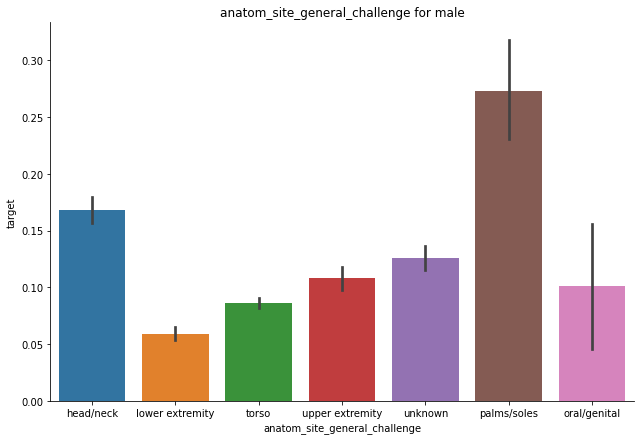

In [252]:
sns.catplot(
    x="anatom_site_general_challenge", 
    y="target", kind="bar", 
    height=6, aspect=1.5, data=df_train[(df_train['sex']=='male')]
)
plt.title("anatom_site_general_challenge for male")

In [253]:
df_train[(df_train['anatom_site_general_challenge']=='unknown') & (df_train['sex']=='female')]['target'].value_counts()

0    1318
1      24
Name: target, dtype: int64

Text(0.5, 1.0, 'anatom_site_general_challenge for female')

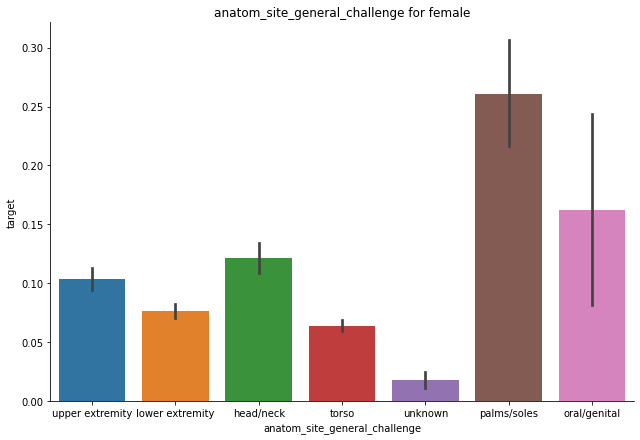

In [254]:
sns.catplot(
    x="anatom_site_general_challenge", 
    y="target", kind="bar", 
    height=6, aspect=1.5, data=df_train[(df_train['sex']=='female')]
)
plt.title("anatom_site_general_challenge for female")

In [0]:
df_train.loc[(df_train['anatom_site_general_challenge']=='unknown') & (df_train['sex']=='male') & (df_train['target']==0), 'anatom_site_general_challenge'] = 'lower extremity'
df_train.loc[(df_train['anatom_site_general_challenge']=='unknown') & (df_train['sex']=='male') & (df_train['target']==1), 'anatom_site_general_challenge'] = 'palms/soles'
df_train.loc[(df_train['anatom_site_general_challenge']=='unknown') & (df_train['sex']=='female') & (df_train['target']==0), 'anatom_site_general_challenge'] = 'torso'
df_train.loc[(df_train['anatom_site_general_challenge']=='unknown') & (df_train['sex']=='female') & (df_train['target']==1), 'anatom_site_general_challenge'] = 'palms/soles'

In [256]:
df_train['anatom_site_general_challenge'].value_counts()

torso              27919
lower extremity    16768
upper extremity     7893
head/neck           6442
palms/soles         1282
oral/genital         183
Name: anatom_site_general_challenge, dtype: int64

In [257]:
df_train['age_approx'].describe()

count    60487.000000
mean        51.082299
std         15.954789
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

In [258]:
df_test['age_approx'].describe()

count    10982.000000
mean        49.525587
std         14.370589
min         10.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

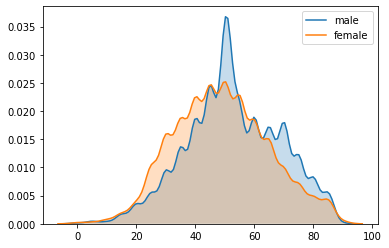

In [259]:
sns.kdeplot(
    df_train.loc[df_train['sex']=='male', 'age_approx'], shade=True,
    label="male"
)
sns.kdeplot(
    df_train.loc[df_train['sex']=='female', 'age_approx'], shade=True,
    label="female"
)

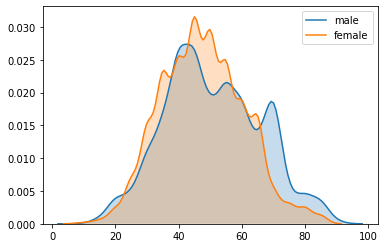

In [260]:
sns.kdeplot(
    df_test.loc[df_test['sex']=='male', 'age_approx'], shade=True,
    label="male"
)
sns.kdeplot(
    df_test.loc[df_test['sex']=='female', 'age_approx'], shade=True,
    label="female"
)

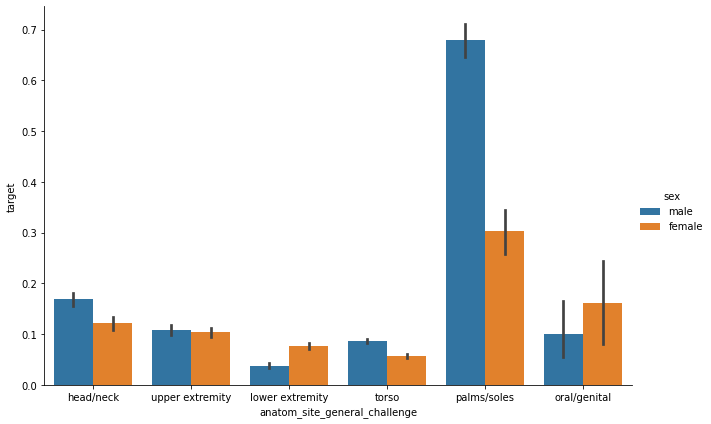

In [261]:
sns.catplot(
    x="anatom_site_general_challenge", 
    y="target", hue="sex", kind="bar", 
    height=6, aspect=1.5, data=df_train
);

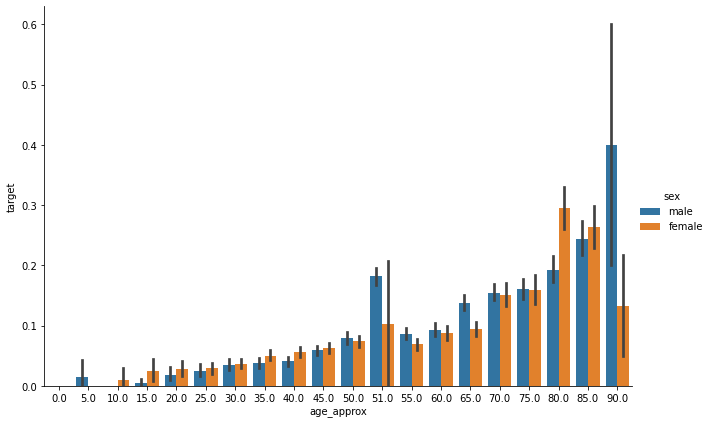

In [262]:
sns.catplot(
    x="age_approx", 
    y="target", hue="sex", kind="bar", 
    height=6, aspect=1.5, data=df_train
);

In [0]:
#df_train = train_copy.copy()

In [276]:
target = 'target'
train_copy = df_train.copy(deep=True)

nunique = df_train.nunique()
types = df_train.dtypes

unused_feat = ['patient_id', 'image_name', 'diagnosis', 'benign_malignant', 'fold']

categorical_columns = []
categorical_dims =  {}
for col in df_train.columns:
    if (types[col] == 'object' or nunique[col] < 25) and (col not in unused_feat):
        print(col, df_train[col].nunique())
        l_enc = LabelEncoder()
        fillna_val = df_train[col].value_counts().index[0]
        df_train[col] = df_train[col].fillna(fillna_val)
        df_train[col] = l_enc.fit_transform(df_train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    #else:
    #    df_train.fillna(df_train.loc[train_indices, col].mean(), inplace=True)

features = [ col for col in df_train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

sex 2
age_approx 20
anatom_site_general_challenge 6
target 2


In [277]:
df_train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,fold,target
0,ISIC_2637011,IP_7279968,1,9,0,2,0
1,ISIC_0015719,IP_3075186,0,9,5,0,0
2,ISIC_0052212,IP_2842074,0,10,1,3,0
3,ISIC_0068279,IP_6890425,0,9,0,1,0
4,ISIC_0074268,IP_8723313,0,12,5,3,0
...,...,...,...,...,...,...,...
60482,ISIC_0013643,ISIC_0013643,1,11,1,4,0
60483,ISIC_0013227,ISIC_0013227,1,11,1,0,0
60484,ISIC_0013595,ISIC_0013595,1,11,1,2,0
60485,ISIC_0012844,ISIC_0012844,1,11,1,0,0


auc score:  0.7033779430675763


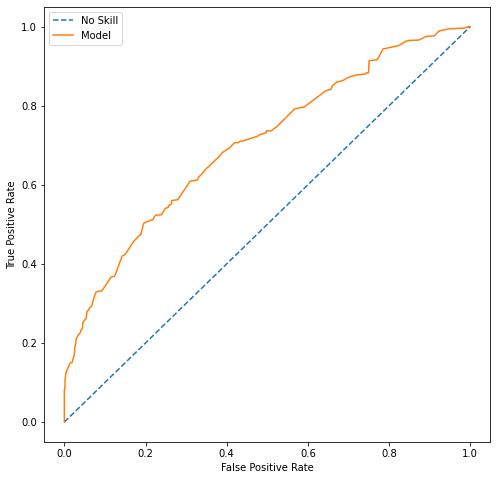

auc score:  0.6985743189977311


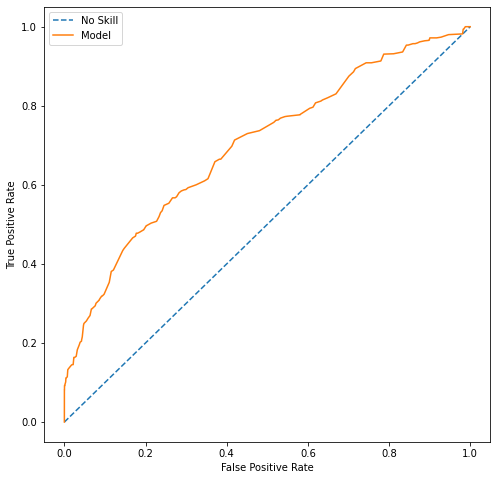

auc score:  0.7198338887888067


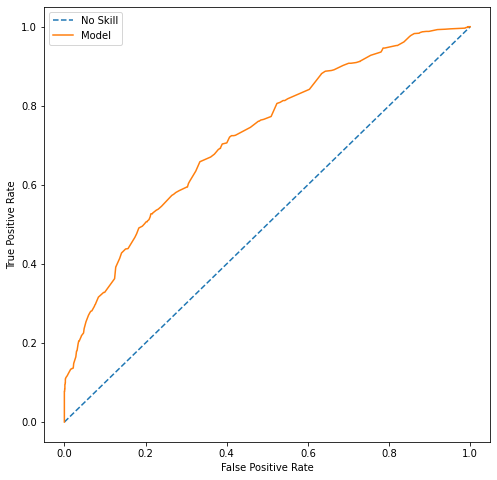

auc score:  0.7196363749537887


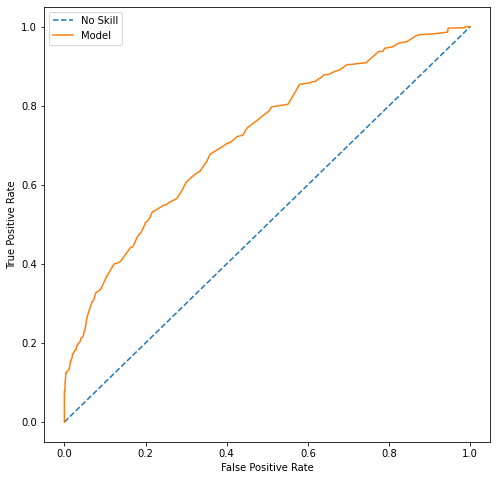

auc score:  0.7584471352739794


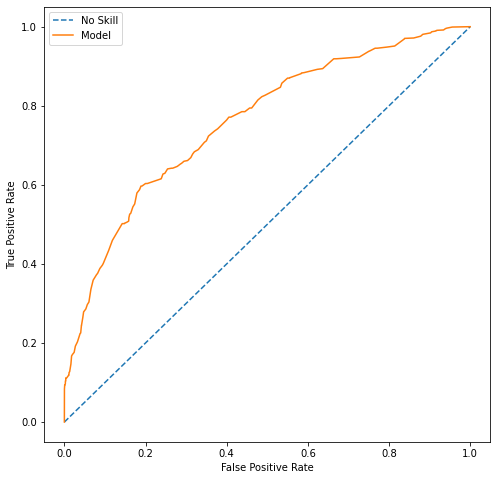

avg_score:  0.7199739322163765


In [290]:
score_list = []
for fold_no in [0, 1, 2, 3, 4]:
    train_indices = df_train[df_train['fold'] != fold_no][[col for col in df_train.columns if col != 'target']].index
    valid_indices = df_train[df_train['fold'] == fold_no][[col for col in df_train.columns if col != 'target']].index
    X_train = df_train[features].values[train_indices]
    y_train = df_train[target].values[train_indices]
    X_val = df_train[features].values[valid_indices]
    y_val = df_train[target].values[valid_indices]
    clf = XGBClassifier(n_estimators=500, n_jobs=4, seed=43)
    clf.fit(X_train, y_train, eval_metric=roc_auc_score)
    y_pred = clf.predict_proba(X_val)
    score = roc_auc_score(y_val, y_pred[:,1])
    score_list.append(score)
    print('auc score: ', score)
    plot_roc(y_val, y_pred[:,1], f'xgb_{str(fold_no)}', True)
print('avg_score: ', np.array(score_list).mean())